In [38]:
class CFG:
    target = "Calories"
    target_means = "Calories_mean"
    target_per_duration = "Calories_Per_Duration"
    target_vars = [target,target_means,target_per_duration]
    folds = 50
    seed = 42
    folder_path = 'playground-series-s5e5_csv/'
    num_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    except_cols = ['id']
    importance_threshold=1e-4

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import zscore, skew
from scipy.stats import ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin,clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from scipy.stats import norm
from sklearn.tree import DecisionTreeRegressor

In [40]:
skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

In [41]:
train = pd.read_csv(CFG.folder_path + 'train.csv')
test = pd.read_csv(CFG.folder_path + 'test.csv')
submission = pd.read_csv(CFG.folder_path + "sample_submission.csv")

In [42]:
def compute_coef_and_se(x, y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    coef = model.coef_[0]
    y_pred = model.predict(x.reshape(-1, 1))
    residuals = y - y_pred
    n = len(y)

    # Standard error of the slope
    se = np.sqrt(np.sum(residuals**2) / (n - 2)) / np.sqrt(np.sum((x - np.mean(x))**2))
    return coef, se

# 1. Data Overview

In [43]:
def data_overview(df, name='data',score_value=3):
    print(f"Overview of {name.upper()}")
    print("="*60)
    
    # Basic information
    print(f"Shape: {df.shape}")
    print("\nColumn Types:")
    print(df.dtypes.value_counts())
    
    # Missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("No missing values.")
    else:
        print(missing)
    
    # Descriptive statistics for numeric columns
    print("\nDescriptive Statistics (Numerical Columns):")
    display(df.describe().T)
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    
    print(f"\nNumeric columns: {numeric_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Count Outlier Ratios and visualize
    print(f"\nOutlier Ratios (z-score > {score_value}):")
    if numeric_cols:
        zscores = df[numeric_cols].apply(lambda col: np.abs(zscore(col.dropna())))
        outlier_ratios = (zscores > 3).mean().sort_values(ascending=False) * 100
        print(outlier_ratios[outlier_ratios > 0].round(2).astype(str) + " %")
        if not outlier_ratios.empty:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=outlier_ratios.index, y=outlier_ratios.values)
            plt.xticks(rotation=45)
            plt.ylabel("Outlier Ratio (%)")
            plt.title(f"Outlier Ratio per Numeric Column (z > {score_value})")
            plt.tight_layout()
            plt.show()
    
    # Histogram for numeric features
    if len(numeric_cols) > 0:
        print("\nHistogram of Numeric Features:")
        df[numeric_cols].hist(bins=30, figsize=(15, 10))
        plt.tight_layout()
        plt.show()
    
    # Value counts for categorical features
    if len(categorical_cols) > 0:
        print("\nValue Counts of Categorical Features:")
        for col in categorical_cols:
            print(f"\n{col} value counts:")
            print(df[col].value_counts())

    # Correlation heatmap (top 10 high-variance numeric features)
    print("\nCorrelation Heatmap (Top 10 by Variance):")
    if len(numeric_cols) > 1:
        top10 = df[numeric_cols].var().sort_values(ascending=False).head(10).index
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[top10].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation among top 10 high-variance features")
        plt.show()
    
    print("="*60)

In [44]:
def compare_distributions(train, test, columns=None, except_cols=None, significance_level=0.05):
    if columns is None:
        # Select numeric columns by default
        columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    if except_cols is not None:
        # Exclude specified columns
        columns = [col for col in columns if col not in except_cols]

    results = []

    for col in columns:
        if col not in test.columns:
            continue  # Skip columns not in test set

        # Kolmogorov-Smirnov test
        # We use the Kolmogorov–Smirnov test because we want to verify whether the entire shape of the distribution
        # —not just the mean or variance—is the same across all data.
        stat, p_value = ks_2samp(train[col].dropna(), test[col].dropna())
        is_different = p_value < significance_level
        results.append({
            'column': col,
            'p_value': p_value,
            'statistic': stat,
            'significant_difference': is_different
        })

        # Plot distribution
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='train', fill=True)
        sns.kdeplot(test[col], label='test', fill=True)
        plt.title(f"Distribution of {col} | p={p_value:.4f} | {'Different' if is_different else 'Similar'}")
        plt.legend()
        plt.show()

    return pd.DataFrame(results)

In [45]:
def find_optimal_bins_by_tree(X_col, y, max_leaf_nodes=6, min_samples_leaf=0.05):
    X_col = np.array(X_col).reshape(-1, 1)

    tree = DecisionTreeRegressor(
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf
    )
    tree.fit(X_col, y)

    thresholds = tree.tree_.threshold
    thresholds = thresholds[thresholds != -2]  # filter out leaf nodes
    return sorted(np.unique(thresholds))

In [46]:
def binning_evaluation(X_col, y, bins, feature_name, model=None, cv=5):
    df = pd.DataFrame({feature_name: X_col, 'target': y})
    df['bin'] = pd.cut(df[feature_name], bins=bins)
    bin_means = df.groupby('bin')['target'].mean()
    df['binned_pred'] = df['bin'].map(bin_means).astype(float)

    # Variance comparison
    original_var = np.var(y)
    binned_var = np.var(df['binned_pred'])
    variance_explained = binned_var / original_var
    variance_reduction = 1 - variance_explained

    # Predictive power via cross-val
    X_cont = X_col.values.reshape(-1, 1)
    X_bin = pd.get_dummies(df['bin'], drop_first=True)

    model = model or LinearRegression()

    r2_cont = cross_val_score(model, X_cont, y, cv=cv, scoring='r2').mean()
    r2_bin = cross_val_score(model, X_bin, y, cv=cv, scoring='r2').mean()

    # Visualization
    plt.figure(figsize=(12, 5))
    sns.histplot(y, bins=50, color='lightgray', label='True Distribution')
    sns.histplot(df['binned_pred'], bins=50, color='red', label='Binned Prediction', alpha=0.5)
    plt.title(f'{feature_name}: True vs Binned Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_name,
        'variance_reduction': variance_reduction,
        'r2_continuous': r2_cont,
        'r2_binned': r2_bin
    }


Overview of TRAIN
Shape: (750000, 8)

Column Types:
float64    6
object     1
int64      1
dtype: int64

Missing Values:
No missing values.

Descriptive Statistics (Numerical Columns):


,count,mean,std,min,25%,50%,75%,max
Age,750000.0,41.420404,15.175049,20.0,28.0,40.0,52.0,79.0
Height,750000.0,174.697685,12.824496,126.0,164.0,174.0,185.0,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.0,74.0,87.0,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.0,15.0,23.0,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.0,95.0,103.0,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.6,40.3,40.7,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.0,77.0,136.0,314.0



Numeric columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
Categorical columns: ['Sex']

Outlier Ratios (z-score > 3):
Body_Temp     0.45 %
Calories      0.04 %
Heart_Rate    0.02 %
Weight        0.01 %
Height        0.01 %
dtype: object


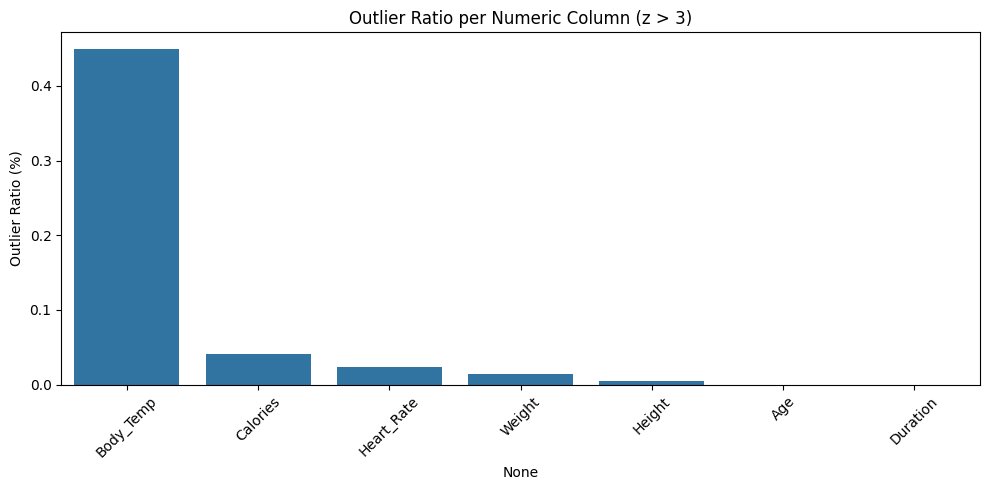


Histogram of Numeric Features:


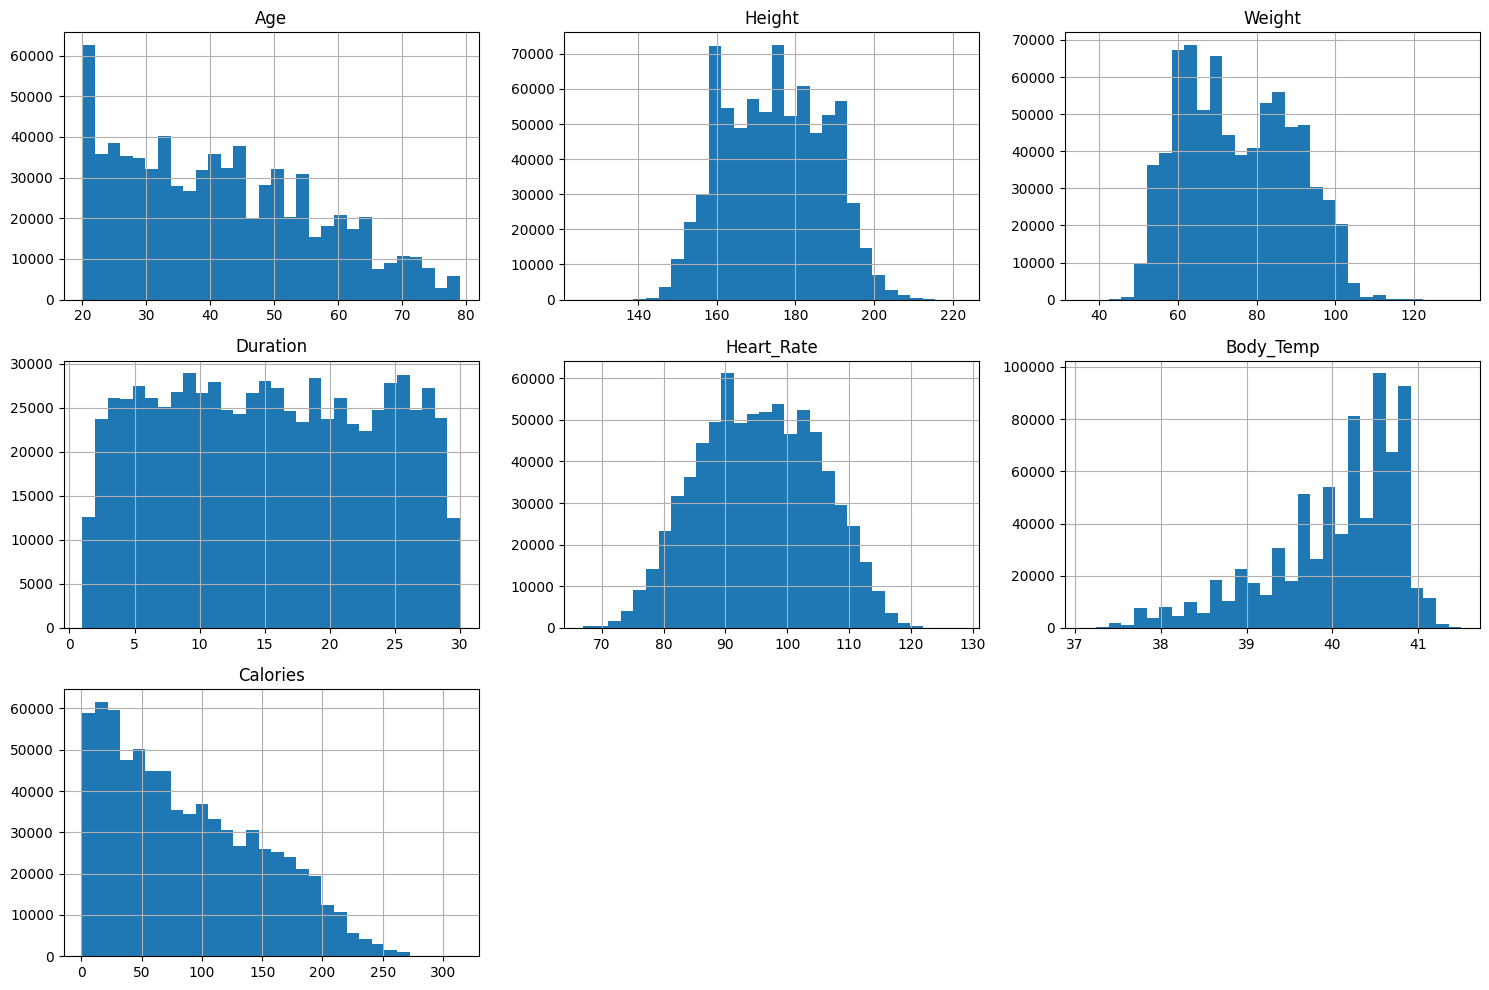


Value Counts of Categorical Features:

Sex value counts:
female    375721
male      374279
Name: Sex, dtype: int64

Correlation Heatmap (Top 10 by Variance):


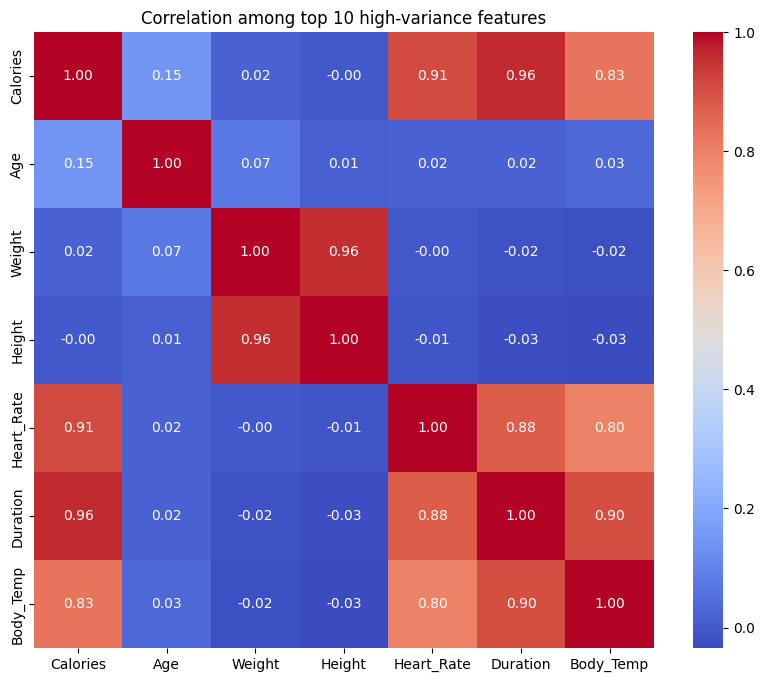

In [47]:
data_overview(train.drop(columns=['id']), name='train',score_value=3)

In [48]:
# max(Body_Temp) = 41.5 ?????
# max(Height) = 222.0 ?????

# I plan to compare outlier removal versus retention during the training process later on.

Overview of TRAIN
Shape: (374279, 7)

Column Types:
float64    6
int64      1
dtype: int64

Missing Values:
No missing values.

Descriptive Statistics (Numerical Columns):


,count,mean,std,min,25%,50%,75%,max
Age,374279.0,41.567724,14.958469,20.0,29.0,40.0,52.0,79.0
Height,374279.0,184.410448,8.589572,141.0,179.0,184.0,191.0,222.0
Weight,374279.0,86.609032,8.951300,46.0,81.0,87.0,93.0,132.0
Duration,374279.0,15.340708,8.449930,1.0,8.0,15.0,23.0,30.0
Heart_Rate,374279.0,95.570366,9.492556,67.0,88.0,95.0,103.0,128.0
Body_Temp,374279.0,40.023803,0.794915,37.1,39.6,40.2,40.7,41.5
Calories,374279.0,89.033683,66.590171,1.0,31.0,73.0,138.0,314.0



Numeric columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
Categorical columns: []

Outlier Ratios (z-score > 3):
Body_Temp     0.48 %
Height        0.39 %
Weight        0.27 %
Calories      0.05 %
Heart_Rate    0.03 %
dtype: object


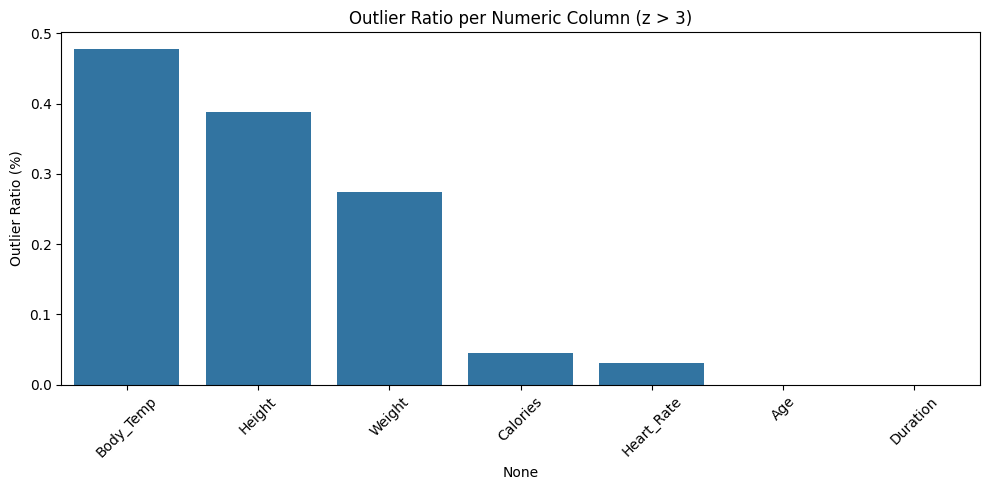


Histogram of Numeric Features:


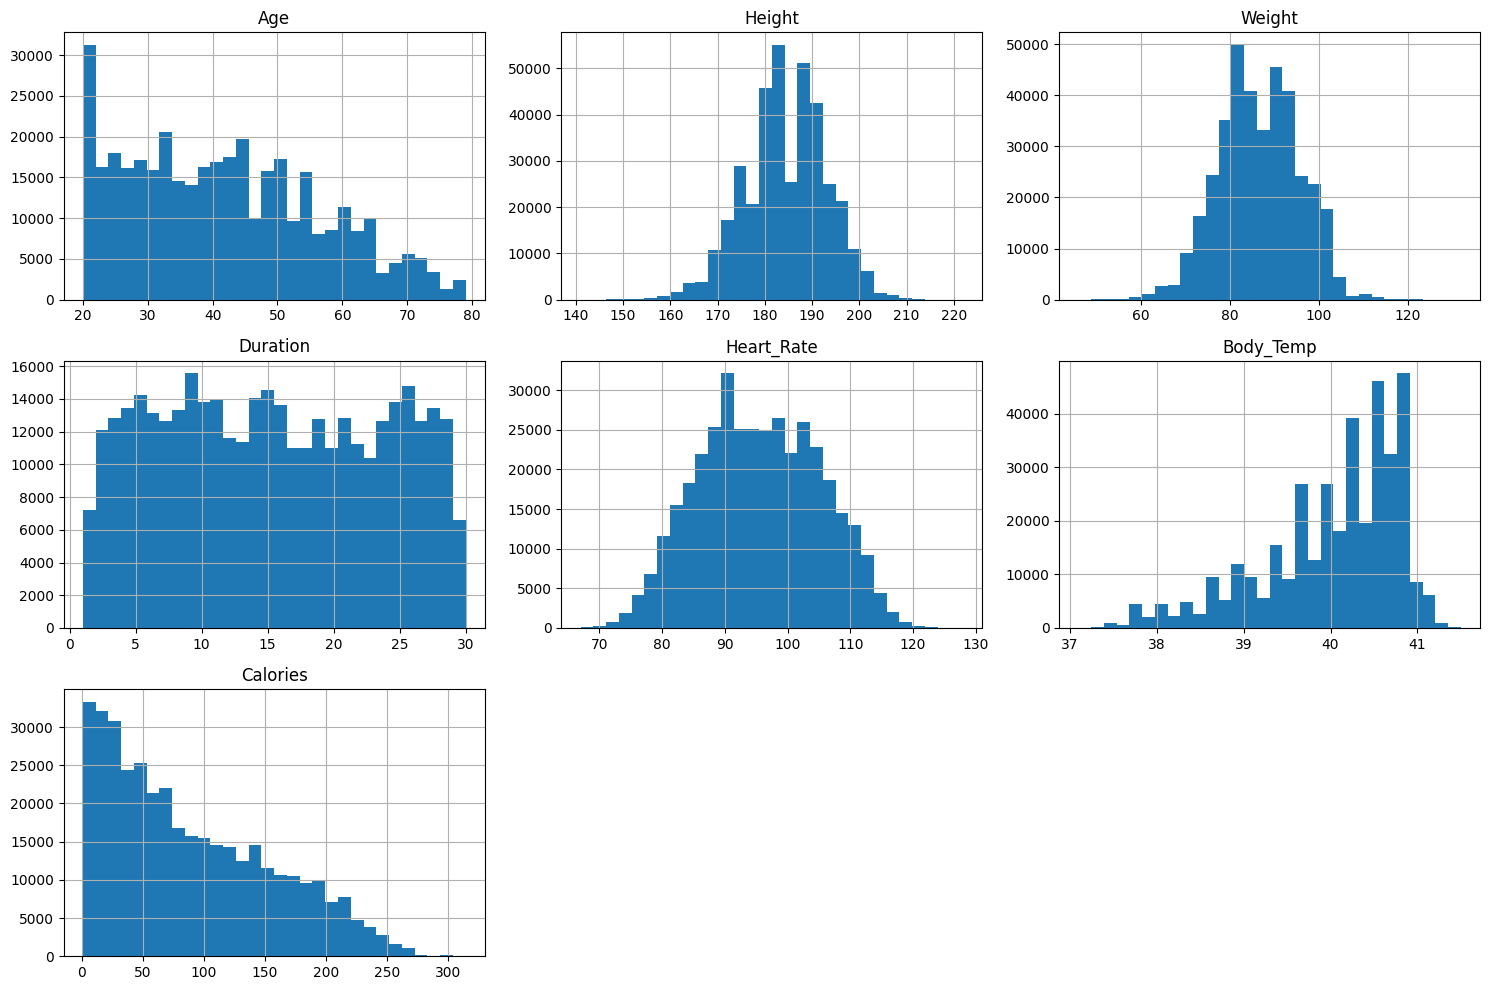


Correlation Heatmap (Top 10 by Variance):


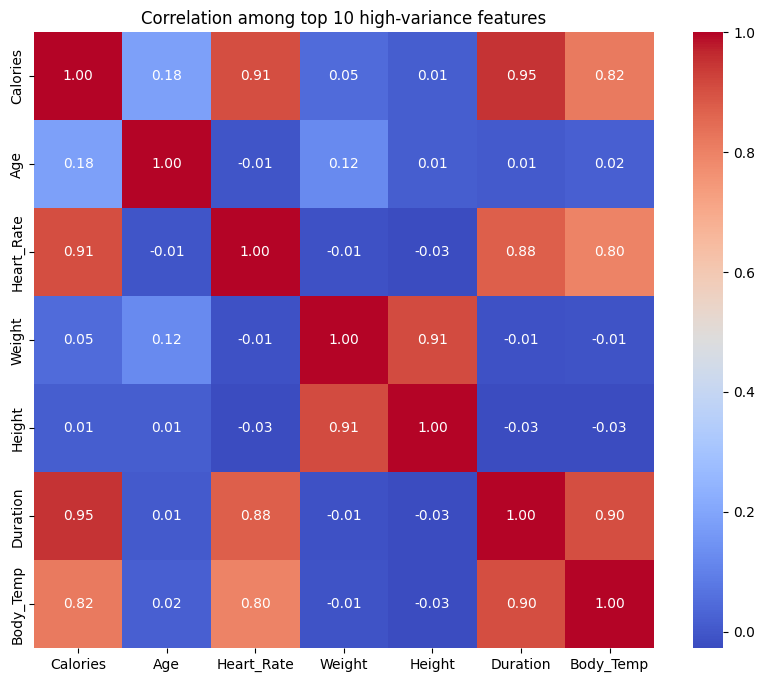

In [49]:
data_overview(train[train['Sex'] == 'male'].drop(columns=['id','Sex']), name='train',score_value=3)

Overview of TRAIN
Shape: (375721, 7)

Column Types:
float64    6
int64      1
dtype: int64

Missing Values:
No missing values.

Descriptive Statistics (Numerical Columns):


,count,mean,std,min,25%,50%,75%,max
Age,375721.0,41.273650,15.386384,20.0,28.0,40.0,52.0,79.0
Height,375721.0,165.022200,8.198525,126.0,159.0,164.0,171.0,222.0
Weight,375721.0,63.726300,7.011194,36.0,59.0,63.0,68.0,111.0
Duration,375721.0,15.501013,8.256757,1.0,8.0,16.0,23.0,30.0
Heart_Rate,375721.0,95.397955,9.406330,67.0,88.0,96.0,103.0,128.0
Body_Temp,375721.0,40.048655,0.764397,37.1,39.6,40.3,40.6,41.5
Calories,375721.0,87.534761,57.905734,1.0,37.0,80.0,133.0,300.0



Numeric columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
Categorical columns: []

Outlier Ratios (z-score > 3):
Body_Temp     0.89 %
Weight        0.45 %
Height        0.27 %
Heart_Rate    0.02 %
Calories       0.0 %
dtype: object


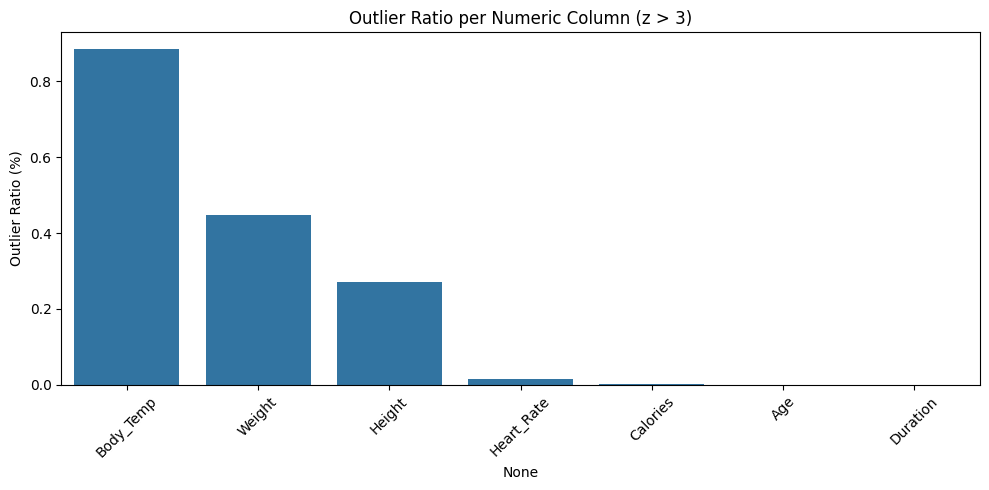


Histogram of Numeric Features:


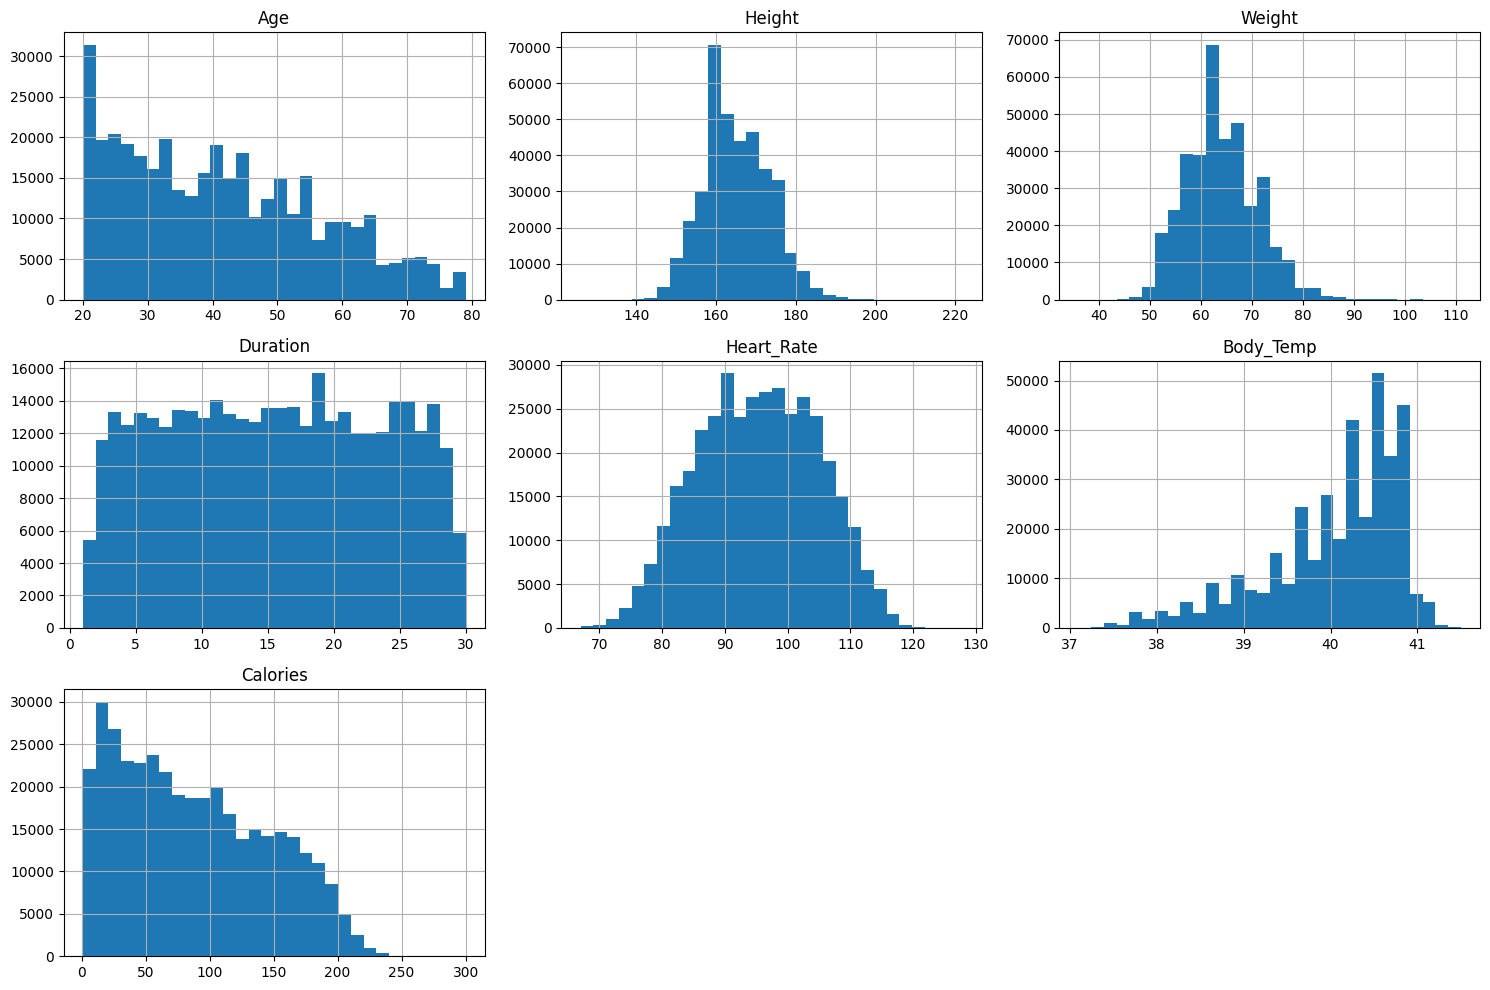


Correlation Heatmap (Top 10 by Variance):


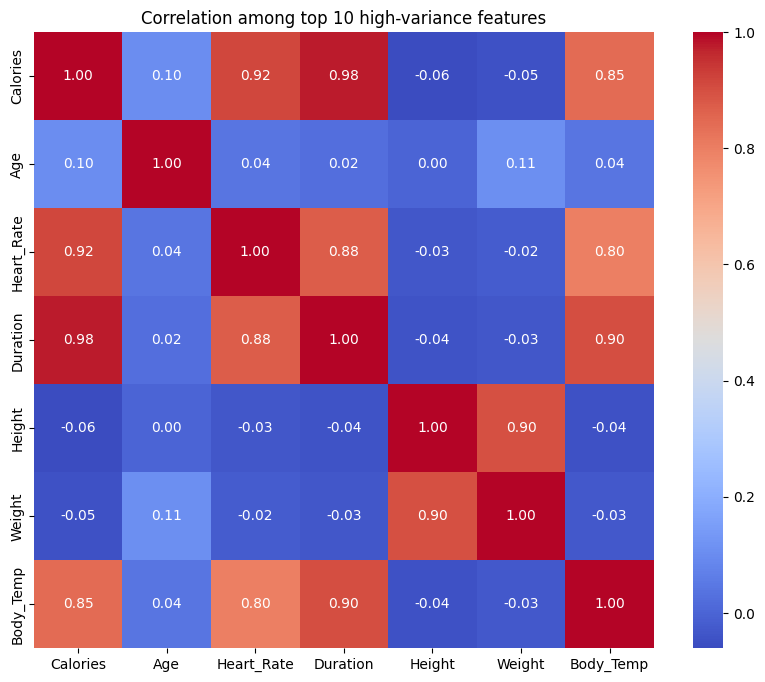

In [50]:
data_overview(train[train['Sex'] == 'female'].drop(columns=['id','Sex']), name='train',score_value=3)

In [51]:
# The variables Heart_Rate, Duration, and Body_temp show changes in their correlation depending on sex.
#          Heart_Rate Duration Body_temp
# Male   : 0.92       0.98     0.85
# Female : 0.91       0.95     0.82


# In the case of males and females, the influence of certain variables may differ.
# Specifically, when looking at the distribution of Weight, the histogram appears bimodal.
# However, if we separate the data by sex and plot the histogram for each group individually, it may turn into a unimodal distribution.

In [52]:
def plot_calorie_hotspots(df, z_thresh=2.0):

    stats = df.groupby(['Duration', 'Heart_Rate'])['Calories'].agg(['mean', 'count']).reset_index()

    global_mean = df['Calories'].mean()
    global_std = df['Calories'].std()

    stats['is_hotspot'] = (stats['mean'] > global_mean + z_thresh * global_std)

    pivot = stats.pivot(index='Duration', columns='Heart_Rate', values='mean')
    hotspot_mask = stats.pivot(index='Duration', columns='Heart_Rate', values='is_hotspot')

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap='Reds', mask=~hotspot_mask.astype(bool), annot=True, fmt=".1f", cbar_kws={'label': 'Mean Calories'})
    plt.title(f" Hotspot: Duration × Heart_Rate (Z > {z_thresh})")
    plt.xlabel("Heart Rate")
    plt.ylabel("Duration")
    plt.tight_layout()
    plt.show()

    return pivot


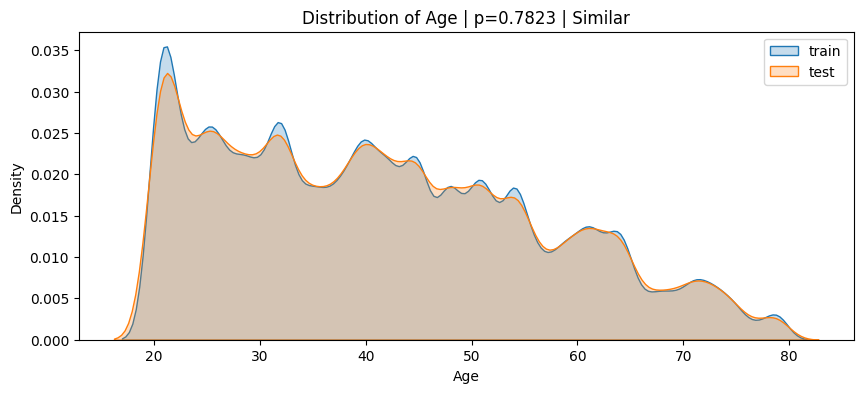

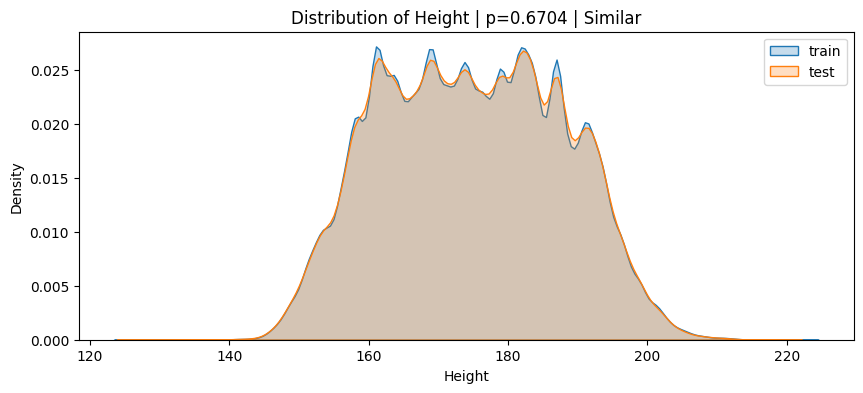

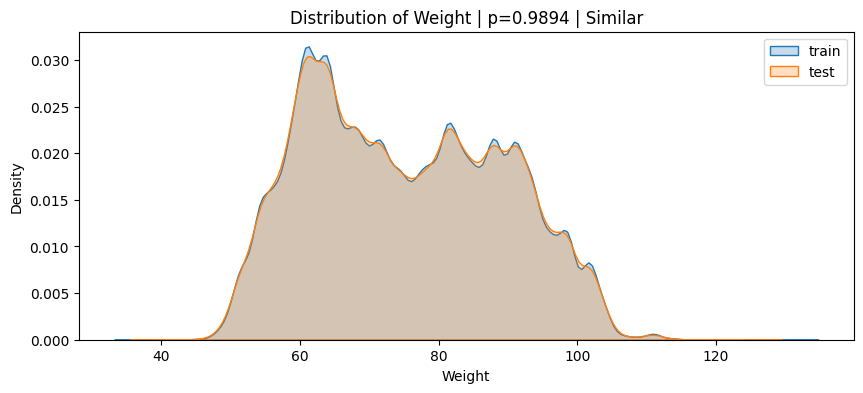

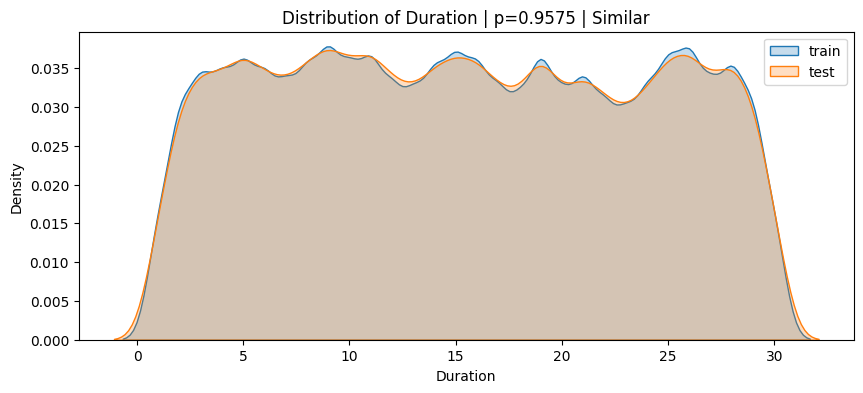

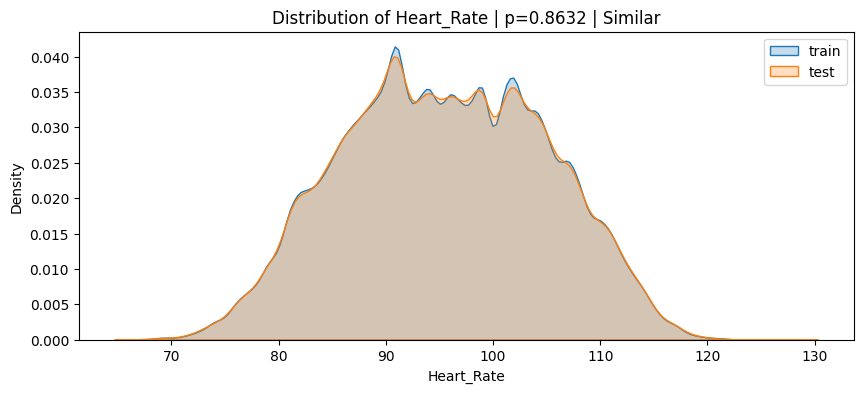

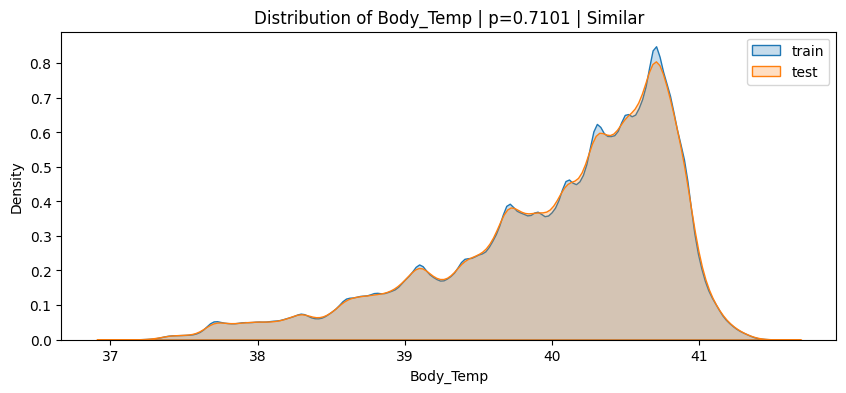

,column,p_value,statistic,significant_difference
0,Age,0.782262,0.001515,False
1,Height,0.670357,0.001672,False
2,Weight,0.989409,0.001023,False
3,Duration,0.957466,0.001176,False
4,Heart_Rate,0.863184,0.001387,False
5,Body_Temp,0.710052,0.001617,False


In [53]:
compare_distributions(train,test,except_cols=['id'])

In [54]:
# The test failed to reject the null hypothesis for all variables,
# which indicates that the distributions in the train and test datasets are statistically similar

In [55]:
# There are records with identical values for all independent variables, but with different values for the target variable.
non_target_cols = train.columns.drop(['id','Calories'])
duplicates = train[train.duplicated(subset=non_target_cols, keep=False)]
print(f"Number of duplicated groups: {duplicates.duplicated(subset=non_target_cols).sum()}")
print(f"Percent of duplicated groups: {len(duplicates)/len(train)*100:.3f}%")
print(f"Total duplicated rows: {len(duplicates)}")

Number of duplicated groups: 7842
Percent of duplicated groups: 1.998%
Total duplicated rows: 14982


<AxesSubplot: xlabel='max_diff', ylabel='Count'>

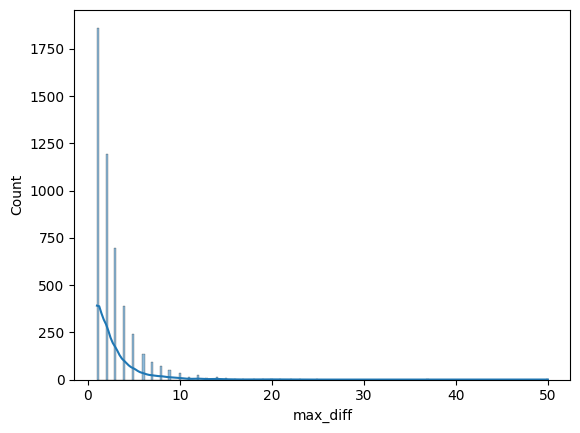

In [56]:
def max_difference_per_duplicate_group(df, target_col):
    other_cols = [col for col in df.columns if col != target_col]
    diff_df = (
        df.groupby(other_cols)[target_col]
        .agg(['min', 'max'])
        .reset_index()
    )
    diff_df['max_diff'] = diff_df['max'] - diff_df['min']
    return diff_df[diff_df['max_diff'] > 0]
max_difference_per_duplicate_group(train.drop(['id'],axis=1),'Calories').sort_values(by = 'max_diff')
sns.histplot(max_difference_per_duplicate_group(train.drop(['id'],axis=1),'Calories')['max_diff'], kde=True)
# This level of difference can be considered as a simple measurement error, 
# so I’ve decided to replace the calorie values with the average value when all other variables are identical.

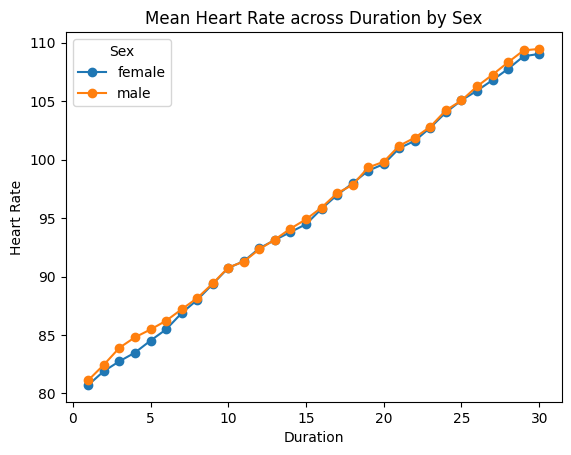

In [57]:
train.groupby(['Duration', 'Sex'])['Heart_Rate'].mean().unstack().plot(kind='line', marker='o')
plt.title("Mean Heart Rate across Duration by Sex")
plt.ylabel("Heart Rate")
plt.show()

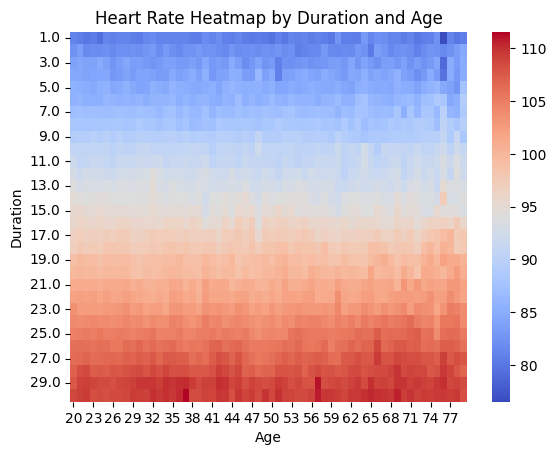

In [58]:
sns.heatmap(train.pivot_table(values='Heart_Rate', index='Duration', columns='Age'), cmap='coolwarm')
plt.title("Heart Rate Heatmap by Duration and Age")
plt.show()

<AxesSubplot: title={'center': 'Heart Rate Std per Duration'}, xlabel='Duration'>

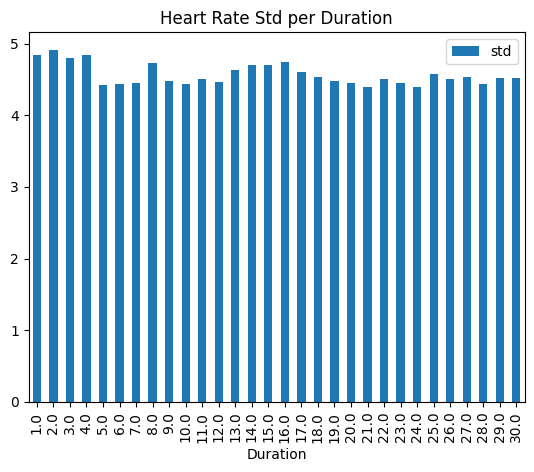

In [59]:
train.groupby('Duration')['Heart_Rate'].agg(['mean', 'std']).plot(kind='bar', y='std', title="Heart Rate Std per Duration")

In [60]:
def regression_coef_ztest(df,group_col,x_col,target_val):
    # male
    X_m = df[df[group_col]=='male'][[x_col]].values
    y_m = df[df[group_col]=='male'][target_val].values
    coef_m, se_m = compute_coef_and_se(X_m, y_m)

    # female
    X_f = df[df[group_col]=='female'][[x_col]].values
    y_f = df[df[group_col]=='female'][target_val].values
    coef_f, se_f = compute_coef_and_se(X_f, y_f)
    # Z-test
    z = (coef_m - coef_f) / np.sqrt(se_m**2 + se_f**2)
    p_value = 2 * (1 - norm.cdf(abs(z)))

    print(f"Male coef = {coef_m:.4f}, SE = {se_m:.4f}")
    print(f"Female coef = {coef_f:.4f}, SE = {se_f:.4f}")
    print(f"Z = {z:.4f}, p-value = {p_value:.4e}")
for col in ['Heart_Rate','Duration','Body_Temp']:
    print(f"\nZ-test for the difference in regression coefficients between genders for variable {col}")
    regression_coef_ztest(train,'Sex',col,'Calories')
    print("="*60)


Z-test for the difference in regression coefficients between genders for variable Heart_Rate
Male coef = 6.3494, SE = 0.0049
Female coef = 5.6456, SE = 0.0040
Z = 111.5521, p-value = 0.0000e+00

Z-test for the difference in regression coefficients between genders for variable Duration
Male coef = 7.4785, SE = 0.0041
Female coef = 6.8500, SE = 0.0025
Z = 132.4628, p-value = 0.0000e+00

Z-test for the difference in regression coefficients between genders for variable Body_Temp
Male coef = 68.3827, SE = 0.0791
Female coef = 64.1219, SE = 0.0658
Z = 41.4129, p-value = 0.0000e+00


The Z-tests for the differences in regression coefficients between males and females show that the effects of Heart Rate, Duration, and Body Temperature on calorie expenditure are statistically significantly different across sexes.
Each p-value is virtually zero (p < 0.0001), indicating that the likelihood of these differences occurring by chance is negligible.

This justifies the creation of sex-specific or masked features, where variables are activated or separated based on sex.
Such conditional feature engineering is widely used in practice—especially in fields like healthcare, fitness, and physiology—where biological responses often vary across demographic groups.

Therefore, introducing interaction terms (e.g., Heart_Rate × Sex) or generating masked variables (e.g., Heart_Rate_Male, Heart_Rate_Female) can improve model performance and interpretability by allowing the model to capture group-specific effects.

In [61]:
optimal_bins = {}
for col in CFG.num_cols:
    bin_edges = find_optimal_bins_by_tree(train[col], train['Calories'], max_leaf_nodes=6)
    # Ensure proper range
    bin_edges = [-np.inf] + bin_edges + [np.inf]
    optimal_bins[col] = bin_edges

# 2.Feature Engineering

In [62]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

# 2-1. Make pipeline

In [63]:
class DomainFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # https://l.myzone.org/b2b/how-does-myzone-calculate-calorie-burn
        # Estimate calorie consumption based on heart rate, body weight, and age, then compare it with the actual consumption.

        # MET_male:    C/min = ((0.6309 * HR) + (0.1988 * weight_kg) + (0.2017 * age) - 55.0969) / 4.184
        # MET_female:  C/min = ((0.4472 * HR) + (0.1263 * weight_kg) + (0.074 * age) - 20.4022) / 4.184
        # = (((0.4472 + Sex * 0.1837) * HR) + ((0.1263 + Sex *0.725) * weight) + ((0.074 + Sex * 0.1277) * Age) - (20.4022 + Sex * 34.6947)) / 4.184
        X['MET'] = (
            ((0.4472 + X['Sex'] * 0.1837) * X['Heart_Rate']) +
            ((0.1263 + X['Sex'] * 0.0725) * X['Weight']) +
            ((0.074 + X['Sex'] * 0.1277) * X['Age']) -
            (20.4022 + X['Sex'] * 34.6947)
        ) / 4.184

        # Calculate heart rate percentage based on HRmax
        # Heart_Rate/(220-Age) * 100
        # 50–60% HRmax: Light exercise (e.g., walking)
        # 70–80% HRmax: Aerobic endurance training
        # 85–95% HRmax: High-intensity interval training (HIIT)
        X['Heart_Rate_hrmax'] = X['Heart_Rate'] / (220 - X['Age']) * 100

        X['Activity_Score'] = X['MET'] * X['Duration']

        # Mifflin-St Jeor BMR calculation method
        # for Man   : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)+5
        # for Woman : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)−161
        X['BMR'] = 10 * X['Weight'] + 6.25 * X['Height'] - 5 * X['Age'] - X['Sex'] * 166 - 161

        # BMI weight/height(m)^2
        X['BMI'] = X['Weight'] / ((X['Height'] / 100) ** 2)

        # Exercise_intensity = Heart_rate / Duration
        X['Exercise_intensity'] = X['Heart_Rate'] / X['Duration'] 
        return X

In [64]:
class InteractionFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy(deep=True) 
        cols = [col for col in X.columns if col in CFG.num_cols]
        new_features = {}

        # Generate interaction features between numerical columns
        for col1 in cols:
            for col2 in cols:
                if col1 != col2:
                    new_features[f"{col1}_x_{col2}"] = X[col1] * X[col2]
                    new_features[f"{col1}_plus_{col2}"] = X[col1] + X[col2]
                    new_features[f"{col1}_minus_{col2}"] = X[col1] - X[col2]
                    new_features[f"{col2}_minus_{col1}"] = X[col2] - X[col1]
                    new_features[f"{col1}_div_{col2}"] = X[col1] / (X[col2] + 1e-5)
                    new_features[f"{col2}_div_{col1}"] = X[col2] / (X[col1] + 1e-5)

        # Row-wise statistical summaries
        new_features["row_mean"] = X[cols].mean(axis=1)
        new_features["row_std"] = X[cols].std(axis=1)
        new_features["row_max"] = X[cols].max(axis=1)
        new_features["row_min"] = X[cols].min(axis=1)
        new_features["row_median"] = X[cols].median(axis=1)

        # Additional row-wise distribution statistics
        new_features["row_skew"] = X[cols].skew(axis=1)
        new_features["row_kurtosis"] = X[cols].kurtosis(axis=1)
        new_features["row_range"] = X[cols].max(axis=1) - X[cols].min(axis=1)

        # Outlier flag using Z-score for each numerical column
        for col in cols:
            z = (X[col] - X[col].mean()) / (X[col].std() + 1e-5)
            new_features[f"{col}_outlier_flag"] = (np.abs(z) > 3).astype(int)

        new_df = pd.DataFrame(new_features, index=X.index)
        X = pd.concat([X, new_df], axis=1)

        return X.copy(deep=True)

In [65]:
class ConditionalInteractionGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, known_durations=None, known_ages=None):
        self.known_durations = known_durations
        self.known_ages = known_ages

    def fit(self, X, y=None):
        if self.known_durations is None:
            self.known_durations = sorted(X['Duration'].unique())
        if self.known_ages is None:
            self.known_ages = sorted(X['Age'].unique())
        return self

    def transform(self, X):
        X = X.copy()
        new_features = {}

        # Duration-based conditional features
        for dur in self.known_durations:
            dur = int(dur)
            mask = (X['Duration'] == dur)

            new_features[f'Heart_Rate_Duration_{dur}'] = np.where(mask, X['Heart_Rate'], 0)
            new_features[f'Body_Temp_Duration_{dur}'] = np.where(mask, X['Body_Temp'], 0)

            new_features[f'Is_Duration_{dur}'] = mask.astype(int)
            new_features[f'HR_to_BT_Duration_{dur}'] = np.where(mask, X['Heart_Rate'] / (X['Body_Temp'] + 1e-5), 0)
            new_features[f'HR_Duration_{dur}_x_Weight'] = np.where(mask, X['Heart_Rate'] * X['Weight'], 0)

        # Age-based conditional features
        for age in self.known_ages:
            age = int(age)
            mask = (X['Age'] == age)

            new_features[f'Heart_Rate_Age_{age}'] = np.where(mask, X['Heart_Rate'], 0)
            new_features[f'Body_Temp_Age_{age}'] = np.where(mask, X['Body_Temp'], 0)

            new_features[f'Is_Age_{age}'] = mask.astype(int)
            new_features[f'HR_to_BT_Age_{age}'] = np.where(mask, X['Heart_Rate'] / (X['Body_Temp'] + 1e-5), 0)
            new_features[f'HR_Age_{age}_x_Weight'] = np.where(mask, X['Heart_Rate'] * X['Weight'], 0)

        new_df = pd.DataFrame(new_features, index=X.index)
        X = pd.concat([X, new_df], axis=1)
        return X

In [66]:
class BinnedHotspotFlagger(BaseEstimator, TransformerMixin):
    def __init__(self, bin_config=None, feature_bins=None, target_col='Calories', z_thresh=2.0, min_count=20):
        self.bin_config = bin_config 
        self.feature_bins = feature_bins or ['Age_bin', 'Duration_bin', 'Heart_Rate_bin']
        self.target_col = target_col
        self.z_thresh = z_thresh
        self.min_count = min_count
        self.hotspot_keys = set()

    def fit(self, X, y=None):
        df = X.copy()

        # Step 1: Binning
        for col, bins in self.bin_config.items():
            df[f'{col}_bin'] = pd.cut(df[col], bins=bins, labels=False)

        # Step 2: Hotspot detection
        if y is not None:
            df_y = df.copy()
            df_y[self.target_col] = y

            grouped = (
                df_y.groupby(self.feature_bins)[self.target_col]
                .agg(['mean', 'count'])
                .reset_index()
            )

            global_mean = df_y[self.target_col].mean()
            global_std = df_y[self.target_col].std()

            hotspots = grouped[
                (grouped['mean'] > global_mean + self.z_thresh * global_std) &
                (grouped['count'] >= self.min_count)
            ]

            self.hotspot_keys = set(tuple(row[self.feature_bins].values) for _, row in hotspots.iterrows())

        return self

    def transform(self, X):
        X = X.copy()

        # Step 1: Binning (again, safely)
        for col, bins in self.bin_config.items():
            X[f'{col}_bin'] = pd.cut(X[col], bins=bins, labels=False)

        # Step 2: Hotspot 플래그 부여 (y는 전혀 사용하지 않음)
        def is_hotspot(row):
            key = tuple(row[bin_col] for bin_col in self.feature_bins)
            return int(key in self.hotspot_keys)

        X['Is_Hotspot'] = X.apply(is_hotspot, axis=1)

        if self.target_col in X.columns:
            X = X.drop(columns=[self.target_col])

        return X

In [67]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, importance_threshold=CFG.importance_threshold):
        self.importance_threshold = importance_threshold
        self.selected_features_ = None

    def fit(self, X, y):
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(random_state=CFG.seed)
        model.fit(X, y)
        importances = model.feature_importances_

        feature_df = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        })

        self.selected_features_ = feature_df[
            feature_df['importance'] >= self.importance_threshold
        ]['feature'].tolist()

        return self

    def transform(self, X):
        return X[self.selected_features_]

# 2-2. Feature generation pipeline definition

In [68]:
known_durations = sorted(train['Duration'].unique())
known_ages = sorted(train['Age'].unique())

In [69]:
def build_domain_feature_pipeline():
    return Pipeline([
        ('domain', DomainFeatureGenerator()),
    ])
def build_interaction_feature_pipeline():
    return Pipeline([
        ('interaction', InteractionFeatureGenerator()),
    ])
def build_conditional_feature_pipeline():
    return Pipeline([
        ('conditional', ConditionalInteractionGenerator(
            known_durations=known_durations,
            known_ages=known_ages
        )),
    ])
def build_binned_hotspot_pipeline():
    return Pipeline([
        ('hotspot', BinnedHotspotFlagger(
            bin_config=optimal_bins,
            min_count=30
        ))
    ])

# 3. Model Training

In [70]:
class HybridFullStackingCV(BaseEstimator, RegressorMixin):
    def __init__(self, pipelines, model_defs, meta_model,
                 n_splits=CFG.folds, random_state=CFG.seed, verbose=True,
                 stratify_feature=None, n_bins=10):
        """
        pipelines: list of sklearn Pipelines
        model_defs: list of (model_class, model_params) tuples
        meta_model: final regressor model (e.g. Ridge)
        stratify_feature: column name in X to be used for stratified KFold
        n_bins: number of bins to discretize stratify_feature into
        """
        self.pipelines = pipelines
        self.model_defs = model_defs
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.random_state = random_state
        self.verbose = verbose
        self.stratify_feature = stratify_feature
        self.n_bins = n_bins
        self.fitted_models_ = []
        self.rmse_scores_ = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        total_models = len(self.pipelines) * len(self.model_defs)
        meta_features = np.zeros((n_samples, total_models))

        # Stratified KFold or regular KFold
        if self.stratify_feature is not None:
            binner = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='quantile')
            stratify_col = binner.fit_transform(X[[self.stratify_feature]]).astype(int).flatten()
            kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        else:
            stratify_col = None
            kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        model_idx = 0
        for pi, pipeline in enumerate(self.pipelines):
            for mi, (model_cls, model_params) in enumerate(self.model_defs):
                if self.verbose:
                    pipeline_name = getattr(pipeline, 'name', f'Pipeline_{pi+1}')
                    print(f"\n Training Pipeline: {pipeline_name} ({pi+1}/{len(self.pipelines)}) + Model {model_cls.__name__}")

                oof_preds = np.zeros(n_samples)
                fold_models = []

                for fold, (train_idx, val_idx) in enumerate(kf.split(X, stratify_col if stratify_col is not None else y)):
                    if self.verbose:
                        print(f"  Fold {fold+1}/{self.n_splits}...")

                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                    pipe = clone(pipeline).fit(X_train)
                    X_train_trans = pipe.transform(X_train)
                    X_val_trans = pipe.transform(X_val)

                    model = model_cls(**model_params)

                    model_name = model.__class__.__name__.lower()
                    fit_kwargs = {'eval_set': [(X_val_trans, y_val)]}
                    if 'xgb' in model_name or 'catboost' in model_name:
                        fit_kwargs['verbose'] = model.get_params().get('verbose', False)

                    model.fit(X_train_trans, y_train, **fit_kwargs)
                    preds = model.predict(X_val_trans)
                    oof_preds[val_idx] = preds
                    fold_models.append((pipe, model))

                    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
                    if self.verbose:
                        print(f"      Fold RMSE: {rmse:.4f}")

                meta_features[:, model_idx] = oof_preds
                self.fitted_models_.append(fold_models)

                rmse_full = np.sqrt(np.mean((meta_features[:, model_idx] - y) ** 2))
                self.rmse_scores_.append(rmse_full)
                if self.verbose:
                    print(f"   OOF RMSE for model {model_idx+1}: {rmse_full:.4f}")

                model_idx += 1

        if self.verbose:
            print(f"\n Fitting meta model: {self.meta_model.__class__.__name__}")

        self.meta_model.fit(meta_features, y)

        if self.verbose:
            meta_preds = self.meta_model.predict(meta_features)
            meta_rmse = np.sqrt(np.mean((meta_preds - y) ** 2))
            print(f" Meta model RMSE on OOF predictions: {meta_rmse:.4f}")

        return self

    def predict(self, X):
        meta_features = []

        for i, fold_models in enumerate(self.fitted_models_):
            fold_preds = []
            for pipe, model in fold_models:
                X_trans = pipe.transform(X)
                fold_preds.append(model.predict(X_trans))

            mean_preds = np.mean(fold_preds, axis=0)
            meta_features.append(mean_preds)

            if self.verbose:
                print(f" Model {i+1}: Aggregated prediction shape = {mean_preds.shape}")

        meta_X = np.vstack(meta_features).T
        final_preds = self.meta_model.predict(meta_X)

        return np.clip(np.expm1(final_preds), 1, 314)

In [71]:
train_X = train.drop(columns=['id', 'Calories'])
train_y = np.log1p(train['Calories'])
test_X = test.drop(columns=['id'])

In [72]:
pipeline1 = build_domain_feature_pipeline()
pipeline2 = build_interaction_feature_pipeline()
pipeline3 = build_conditional_feature_pipeline()
pileline4 = build_binned_hotspot_pipeline()
pipelines = [pipeline1, pipeline2, pipeline3, pileline4]

In [73]:
model_defs = [
    (CatBoostRegressor, {
        'iterations': 4000, 'learning_rate': 0.01, 'depth': 12,
        'loss_function': 'RMSE', 'l2_leaf_reg': 5, 'random_seed': CFG.seed,
        'eval_metric': 'RMSE', 'early_stopping_rounds': 200,
        'cat_features': ['Sex'], 'verbose': 0, 'task_type': 'GPU'
    }),
    (XGBRegressor, {
        'max_depth': 9, 'colsample_bytree': 0.7, 'subsample': 0.8,
        'n_estimators': 4000, 'learning_rate': 0.01, 'gamma': 0.01,
        'max_delta_step': 2, 'eval_metric': 'rmse', 'enable_categorical': False,
        'random_state': CFG.seed, 'early_stopping_rounds': 200,
        'tree_method': 'hist', 'device': 'cuda'
    })
]

In [74]:
ensemble = HybridFullStackingCV(
    pipelines=pipelines,
    model_defs=model_defs,
    meta_model=Ridge(),
    stratify_feature='Duration',
    n_bins=10,
    verbose=True
)
ensemble.fit(train_X, train_y)

c:\Users\namwonjin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(



 Training Pipeline: Pipeline_1 (1/4) + Model CatBoostRegressor
  Fold 1/50...
      Fold RMSE: 0.0593
  Fold 2/50...
      Fold RMSE: 0.0587
  Fold 3/50...
      Fold RMSE: 0.0603
  Fold 4/50...
      Fold RMSE: 0.0589
  Fold 5/50...
      Fold RMSE: 0.0634
  Fold 6/50...
      Fold RMSE: 0.0577
  Fold 7/50...
      Fold RMSE: 0.0552
  Fold 8/50...
      Fold RMSE: 0.0623
  Fold 9/50...
      Fold RMSE: 0.0642
  Fold 10/50...
      Fold RMSE: 0.0585
  Fold 11/50...
      Fold RMSE: 0.0566
  Fold 12/50...
      Fold RMSE: 0.0590
  Fold 13/50...
      Fold RMSE: 0.0596
  Fold 14/50...
      Fold RMSE: 0.0565
  Fold 15/50...
      Fold RMSE: 0.0607
  Fold 16/50...
      Fold RMSE: 0.0623
  Fold 17/50...
      Fold RMSE: 0.0591
  Fold 18/50...
      Fold RMSE: 0.0602
  Fold 19/50...
      Fold RMSE: 0.0574
  Fold 20/50...
      Fold RMSE: 0.0607
  Fold 21/50...
      Fold RMSE: 0.0623
  Fold 22/50...
      Fold RMSE: 0.0601
  Fold 23/50...
      Fold RMSE: 0.0565
  Fold 24/50...
      Fol

c:\Users\namwonjin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:729: UserWarning: [01:38:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


      Fold RMSE: 0.0593
  Fold 2/50...
      Fold RMSE: 0.0584
  Fold 3/50...
      Fold RMSE: 0.0605
  Fold 4/50...
      Fold RMSE: 0.0581
  Fold 5/50...
      Fold RMSE: 0.0654
  Fold 6/50...
      Fold RMSE: 0.0567
  Fold 7/50...
      Fold RMSE: 0.0550
  Fold 8/50...
      Fold RMSE: 0.0623
  Fold 9/50...
      Fold RMSE: 0.0636
  Fold 10/50...
      Fold RMSE: 0.0575
  Fold 11/50...
      Fold RMSE: 0.0560
  Fold 12/50...
      Fold RMSE: 0.0593
  Fold 13/50...
      Fold RMSE: 0.0577
  Fold 14/50...
      Fold RMSE: 0.0557
  Fold 15/50...
      Fold RMSE: 0.0596
  Fold 16/50...
      Fold RMSE: 0.0616
  Fold 17/50...
      Fold RMSE: 0.0585
  Fold 18/50...
      Fold RMSE: 0.0598
  Fold 19/50...
      Fold RMSE: 0.0573
  Fold 20/50...
      Fold RMSE: 0.0596
  Fold 21/50...
      Fold RMSE: 0.0627
  Fold 22/50...
      Fold RMSE: 0.0597
  Fold 23/50...
      Fold RMSE: 0.0562
  Fold 24/50...
      Fold RMSE: 0.0609
  Fold 25/50...
      Fold RMSE: 0.0592
  Fold 26/50...
      Fo

HybridFullStackingCV(meta_model=Ridge(),
                     model_defs=[(<class 'catboost.core.CatBoostRegressor'>,
                                  {'cat_features': ['Sex'], 'depth': 12,
                                   'early_stopping_rounds': 200,
                                   'eval_metric': 'RMSE', 'iterations': 4000,
                                   'l2_leaf_reg': 5, 'learning_rate': 0.01,
                                   'loss_function': 'RMSE', 'random_seed': 42,
                                   'task_type': 'GPU', 'verbose': 0}),
                                 (<class 'xgboost.sklearn.XGBRegressor'>,
                                  {'cols...
                                                                                                40.32499885559082,
                                                                                                40.64999961853027,
                                                                                                40.78603172302246,
                                                                                                inf],
                                                                                  'Duration': [-inf,
                                                                                               6.5,
                                                                                               10.5,
                                                                                               14.5,
                                                                                               18.5,
                                                                                               24.5,
                                                                                               inf],
                                                                                  'Heart_Rate': [-inf,
                                                                                                 86.5,
                                                                                                 91.5,
                                                                                                 98.5,
                                                                                                 102.5,
                                                                                                 105.5,
                                                                                                 inf],
                                                                                  'Height': [-inf,
                                                                                             159.5,
                                                                                             173.5,
                                                                                             187.5,
                                                                                             191.5,
                                                                                             194.5,
                                                                                             inf],
                                                                                  'Weight': [-inf,
                                                                                             62.5,
                                                                                             79.5,
                                                                                             87.5,
                                                                                             90.5,
                                                                                             96.5,
                                                                                             inf]},
                                                      

In [75]:
final_preds = ensemble.predict(test_X)

 Model 1: Aggregated prediction shape = (250000,)
 Model 2: Aggregated prediction shape = (250000,)
 Model 3: Aggregated prediction shape = (250000,)
 Model 4: Aggregated prediction shape = (250000,)
 Model 5: Aggregated prediction shape = (250000,)
 Model 6: Aggregated prediction shape = (250000,)
 Model 7: Aggregated prediction shape = (250000,)
 Model 8: Aggregated prediction shape = (250000,)


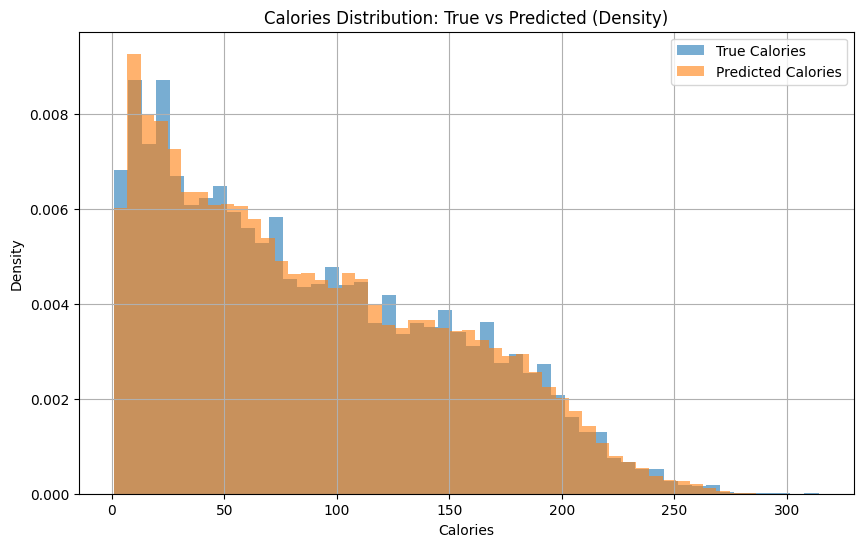

In [76]:
true_calories = np.expm1(train_y)

plt.figure(figsize=(10, 6))
plt.hist(true_calories, bins=50, alpha=0.6, label="True Calories", density=True)
plt.hist(final_preds, bins=50, alpha=0.6, label="Predicted Calories", density=True)
plt.title("Calories Distribution: True vs Predicted (Density)")
plt.xlabel("Calories")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
submission = pd.DataFrame({
    'id': test['id'],
    'Calories': final_preds 
})

submission.to_csv("ensenble_final_submission.csv", index=False)

# extra.Training each preprocessing and machine learning model combination separately, followed by ensemble.

In [ ]:

import itertools

kf = KFold(n_splits=5, shuffle=True, random_state=CFG.seed)

for i, (pipeline, (model_class, model_params)) in enumerate(itertools.product(pipelines, model_defs)):
    print(f"Training pipeline-model combination {i+1}/12")

    test_preds = np.zeros(len(test_X))

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_tr, X_val = train_X.iloc[train_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

        fitted_pipeline = clone(pipeline).fit(X_tr, y_tr)
        X_tr_transformed = fitted_pipeline.transform(X_tr)
        X_test_transformed = fitted_pipeline.transform(test_X)

        model = model_class(**model_params)
        model.fit(
            X_tr_transformed, y_tr,
            eval_set=[(fitted_pipeline.transform(X_val), y_val)],
            eval_metric='RMSE',
            early_stopping_rounds=50,
            verbose=False
        )
        
        test_preds += model.predict(X_test_transformed) / CFG.folds

    pd.DataFrame({'preds': test_preds}).to_csv(f'submission_{i}.csv', index=False)


Training pipeline-model combination 1/12


TypeError: CatBoostRegressor.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
preds = []
for i in range(12):
    df = pd.read_csv(f'submission_{i}.csv')
    preds.append(df['preds'].values)

preds = np.array(preds)  # shape: (12, N)
preds = preds.T  # shape: (N, 12)

In [ ]:
train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(train_X, train_y, test_size=0.2, random_state=CFG.seed)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    weights = [trial.suggest_float(f'w{i}', 0, 1) for i in range(12)]
    weights = np.array(weights)
    weights = weights / np.sum(weights)

    blended = np.dot(preds, weights)
    return mean_squared_error(val_y_split, blended, squared=False)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
w = np.array([best_weights[f'w{i}'] for i in range(12)])
w = w / np.sum(w)

final_pred = np.dot(preds, w)

submission = pd.DataFrame({'preds': final_pred})
submission.to_csv('submission_ensemble_each_models.csv', index=False)